# NLP - recommender

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

In [6]:
# YOUR CODE HERE
movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')

Merge movies and ratings

In [7]:
movies['genres'] = movies['genres'].str.replace('|',' ')
ratings = ratings.dropna(subset=['rating'])
movies = movies.merge(ratings, how='left', on='movieId').dropna().drop(columns=['userId', 'rating', 'timestamp']).drop_duplicates()
movies.head()

<ipython-input-7-33397a8af2aa>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
215,2,Jumanji (1995),Adventure Children Fantasy
325,3,Grumpier Old Men (1995),Comedy Romance
377,4,Waiting to Exhale (1995),Comedy Drama Romance
384,5,Father of the Bride Part II (1995),Comedy


Merge the movies and tags

In [8]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
tags['tag'] = tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))
tags_new = tags.drop(columns=['userId', 'timestamp']).drop_duplicates()
merged_df = movies.merge(tags_new, on='movieId', how='left')

In [9]:
merged_df.loc[merged_df['tag'].isna(),'tag'] = ''
merged_df['metadata'] = merged_df['genres'] +" " + merged_df['tag']
merged_df.drop(columns=['genres', 'tag'], inplace=True)

## Vectorizer metadata column

In [11]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(merged_df['metadata'])
count_df = pd.DataFrame(X.toarray())

## Reduction of Dimensionality

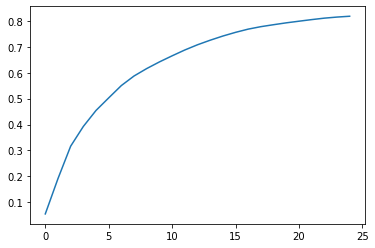

In [17]:
svd = TruncatedSVD(n_components=25)
svd.fit(count_df)
plt.plot(np.cumsum(svd.explained_variance_ratio_))

Transform and reduce dimensionality

In [18]:
latent_df = pd.DataFrame(svd.transform(count_df))
latent_df['title'] = merged_df['title']
latent_df = latent_df.set_index('title')

## Pivot table for user rating

In [20]:
ratings1 = pd.merge(movies[['movieId']], ratings, on="movieId", how="right")
ratings2 = ratings1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
display(ratings2.head())
ratings2.shape

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


(9724, 610)

Reduce dimensionality of ratings using svd

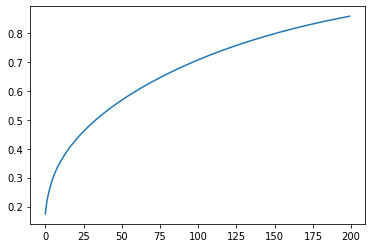

In [21]:
svd = TruncatedSVD(n_components=200)
svd.fit(ratings2)
plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [23]:
latent_df_2 = pd.DataFrame(svd.transform(ratings2))
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,37.649828,-6.380094,14.994617,0.286947,-1.887147,4.790050,8.807629,-2.198636,1.153305,1.387562,...,2.806467,1.477835,3.376922,-0.683546,-2.453425,0.873368,-1.106677,1.034396,-0.256247,0.017236
1,20.596193,-0.477880,10.865916,-8.635795,-3.072411,-0.517149,4.359215,-3.821408,-3.394117,0.236475,...,0.846336,0.580012,-0.508964,0.088315,0.958863,0.357508,-1.465016,2.121398,-1.962242,-0.200842
2,8.504182,-5.714924,3.441693,-6.382810,0.024162,-0.783433,-1.423027,-0.542292,3.270655,1.897236,...,0.551213,-0.565287,-0.485729,0.092326,0.726392,-1.083023,-0.694631,-0.290319,0.278491,0.957538
3,0.465720,-0.828101,0.954583,-0.239080,-0.735695,-0.877414,0.214720,-0.527368,0.079467,0.015617,...,0.140362,-0.020793,-0.134705,0.199995,-0.123079,0.395448,0.025150,0.097005,-0.012230,0.262184
4,6.071045,-2.673536,4.698195,-4.415807,-3.714221,-1.673627,1.297653,-1.308023,1.325734,1.229592,...,0.113977,0.052608,0.061779,0.050435,0.338957,-0.977103,0.051043,0.561062,1.261022,-0.544742


**👉 Reindex by the film title.**

In [24]:
latent_df_2.reset_index(inplace=True)
latent_df_2.rename(columns = {'index': 'movieId'}, inplace=True)
latent_df_2['movieId'] = latent_df_2['movieId'] + 1
latent_df_2 = latent_df_2.merge(movies, on='movieId', how='left').drop(columns=['movieId', 'genres']).set_index('title')
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),37.649828,-6.380094,14.994617,0.286947,-1.887147,4.790050,8.807629,-2.198636,1.153305,1.387562,...,2.806467,1.477835,3.376922,-0.683546,-2.453425,0.873368,-1.106677,1.034396,-0.256247,0.017236
Jumanji (1995),20.596193,-0.477880,10.865916,-8.635795,-3.072411,-0.517149,4.359215,-3.821408,-3.394117,0.236475,...,0.846336,0.580012,-0.508964,0.088315,0.958863,0.357508,-1.465016,2.121398,-1.962242,-0.200842
Grumpier Old Men (1995),8.504182,-5.714924,3.441693,-6.382810,0.024162,-0.783433,-1.423027,-0.542292,3.270655,1.897236,...,0.551213,-0.565287,-0.485729,0.092326,0.726392,-1.083023,-0.694631,-0.290319,0.278491,0.957538
Waiting to Exhale (1995),0.465720,-0.828101,0.954583,-0.239080,-0.735695,-0.877414,0.214720,-0.527368,0.079467,0.015617,...,0.140362,-0.020793,-0.134705,0.199995,-0.123079,0.395448,0.025150,0.097005,-0.012230,0.262184
Father of the Bride Part II (1995),6.071045,-2.673536,4.698195,-4.415807,-3.714221,-1.673627,1.297653,-1.308023,1.325734,1.229592,...,0.113977,0.052608,0.061779,0.050435,0.338957,-0.977103,0.051043,0.561062,1.261022,-0.544742


## Cosine similarity

In [26]:
content_similarity = cosine_similarity(latent_df)
collaborative_similarity = cosine_similarity(latent_df_2)
hybrid_similarity = (content_similarity + collaborative_similarity) / 2

In [27]:
hybrid_similarity = pd.DataFrame(hybrid_similarity)
hybrid_similarity.index = latent_df.index
hybrid_similarity.columns = list(latent_df.index)

In [28]:
content_similarity = pd.DataFrame(content_similarity)
content_similarity.index = latent_df.index
content_similarity.columns = list(latent_df.index)

In [29]:
collaborative_similarity = pd.DataFrame(collaborative_similarity)
collaborative_similarity.index = latent_df.index
collaborative_similarity.columns = list(latent_df.index)

In [30]:
collaborative_similarity.sort_values(by='Toy Story (1995)', ascending=False).head()

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.468176,0.360248,0.022684,0.381036,0.409826,0.346877,0.182202,0.290528,0.439849,...,-0.003692,-0.003692,-0.003692,-0.003692,-0.003692,-0.003692,-0.003692,-0.003692,-0.003692,0.015659
Toy Story 2 (1999),0.637400,0.464174,0.189173,0.022993,0.158208,0.294056,0.181907,0.135703,0.038404,0.328354,...,-0.012793,-0.012793,-0.012793,-0.012793,-0.012793,-0.012793,-0.012793,-0.012793,-0.012793,-0.009503
Independence Day (a.k.a. ID4) (1996),0.621923,0.552429,0.452134,0.098869,0.429194,0.528573,0.438605,0.157650,0.406282,0.541107,...,-0.006879,-0.006879,-0.006879,-0.006879,-0.006879,-0.006879,-0.006879,-0.006879,-0.006879,0.019389
Jurassic Park (1993),0.617725,0.611301,0.344451,0.164445,0.332062,0.457684,0.319158,0.187514,0.097593,0.624370,...,-0.008976,-0.008976,-0.008976,-0.008976,-0.008976,-0.008976,-0.008976,-0.008976,-0.008976,-0.010555
Mission: Impossible (1996),0.604911,0.515572,0.438270,0.041803,0.396567,0.508241,0.466175,0.160547,0.383446,0.623204,...,-0.011977,-0.011977,-0.011977,-0.011977,-0.011977,-0.011977,-0.011977,-0.011977,-0.011977,0.011066


In [31]:
content_similarity.sort_values(by='Toy Story (1995)', ascending=False).head()

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.722534,0.312845,0.255561,0.442246,-0.000530,0.312956,0.632140,-0.000896,0.257587,...,0.475318,0.321353,0.313378,0.455013,0.000030,0.670353,0.774909,-0.000114,0.320789,0.443362
"Wild, The (2006)",0.999662,0.726008,0.316195,0.258324,0.446496,0.000175,0.316433,0.633109,0.000324,0.258499,...,0.476263,0.315532,0.316331,0.446727,0.000017,0.670655,0.774553,-0.000068,0.315798,0.447492
Shrek the Third (2007),0.999662,0.726008,0.316195,0.258324,0.446496,0.000175,0.316433,0.633109,0.000324,0.258499,...,0.476263,0.315532,0.316331,0.446727,0.000017,0.670655,0.774553,-0.000068,0.315798,0.447492
"Tale of Despereaux, The (2008)",0.999662,0.726008,0.316195,0.258324,0.446496,0.000175,0.316433,0.633109,0.000324,0.258499,...,0.476263,0.315532,0.316331,0.446727,0.000017,0.670655,0.774553,-0.000068,0.315798,0.447492
Asterix and the Vikings (Astérix et les Vikings) (2006),0.999662,0.726008,0.316195,0.258324,0.446496,0.000175,0.316433,0.633109,0.000324,0.258499,...,0.476263,0.315532,0.316331,0.446727,0.000017,0.670655,0.774553,-0.000068,0.315798,0.447492


In [32]:
hybrid_similarity.sort_values(by='Toy Story (1995)', ascending=False).head()

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.595355,0.336547,0.139123,0.411641,0.204648,0.329917,0.407171,0.144816,0.348718,...,0.235813,0.158831,0.154843,0.225661,-0.001831,0.333330,0.385608,-0.001903,0.158549,0.229510
Toy Story 2 (1999),0.792100,0.513499,0.216851,0.111416,0.251993,0.147528,0.213074,0.317003,0.018817,0.264755,...,0.243603,0.245184,0.116318,0.349716,-0.006808,0.344105,0.398725,-0.006379,0.244891,0.168801
"Monsters, Inc. (2001)",0.775623,0.583433,0.248455,0.138377,0.336424,0.145756,0.223224,0.364976,0.005202,0.293141,...,0.237221,0.156856,0.157255,0.222453,-0.000901,0.334418,0.386367,-0.000944,0.156989,0.263247
Shrek (2001),0.750969,0.532028,0.368524,0.252089,0.296341,0.157888,0.359986,0.327843,0.009304,0.316316,...,0.224065,0.151053,0.151104,0.211078,0.006910,0.313396,0.361057,0.006873,0.151035,0.249782
"Bug's Life, A (1998)",0.713742,0.400888,0.255172,0.148092,0.340206,0.170572,0.238705,0.411690,0.014921,0.310245,...,0.274365,0.187129,0.185498,0.260985,0.009482,0.259548,0.298575,0.009450,0.186879,0.250737
